# Load dataset

In [1]:
import numpy as np

# Load the data
X = np.load('data/X_pizza_sandwitch.npy')
y = np.load('data/y_pizza_sandwitch.npy')

print("Dataset loaded successfully.")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Dataset loaded successfully.
X shape: (4353, 299, 299, 3), y shape: (4353,)


### Check data range for each pixel to determine if it requires scaling to -1: 1

In [2]:
import numpy as np
print(f"Example of X: {X[0]}")
print(f"Min value: {np.min(X)}")
print(f"Max value: {np.max(X)}")

Example of X: [[[-0.7411765  -0.7411765  -0.7254902 ]
  [-0.7411765  -0.8117647  -0.77254903]
  [-0.78039217 -0.81960785 -0.7647059 ]
  ...
  [-0.54509807 -0.69411767 -0.8039216 ]
  [-0.58431375 -0.73333335 -0.7882353 ]
  [-0.42745095 -0.69411767 -0.6862745 ]]

 [[-0.827451   -0.81960785 -0.7882353 ]
  [-0.77254903 -0.8117647  -0.7647059 ]
  [-0.79607844 -0.8039216  -0.75686276]
  ...
  [-0.6        -0.7490196  -0.85882354]
  [-0.58431375 -0.78039217 -0.81960785]
  [-0.30196077 -0.58431375 -0.5686275 ]]

 [[-0.84313726 -0.81960785 -0.7647059 ]
  [-0.8039216  -0.8117647  -0.7647059 ]
  [-0.77254903 -0.7647059  -0.7254902 ]
  ...
  [-0.52156866 -0.69411767 -0.79607844]
  [-0.6156863  -0.69411767 -0.7882353 ]
  [-0.5137255  -0.7254902  -0.78039217]]

 ...

 [[ 0.827451    0.92156863  0.84313726]
  [ 0.7490196   0.827451    0.7411765 ]
  [ 0.81960785  0.84313726  0.77254903]
  ...
  [-0.36470586 -0.41960782 -0.4823529 ]
  [-0.36470586 -0.38823527 -0.44313723]
  [-0.3333333  -0.35686272 -0.

### Check size of each class
- Normally i would try to balance each classes to get smoother training progress
- However, as we are working (for now) on pre-trained network, it may not be required if difference is not huge
- Just we prefer to include other metrics than accuracy to analyze at the end of fitting

In [3]:
unique, counts = np.unique(y, return_counts=True)
print("Check elements of each class")
for class_label, count in zip(unique, counts):
    class_name = "Pizza" if class_label == 0 else "Sandwich"
    print(f"{class_name}: {count} samples")

Check elements of each class
Pizza: 1890 samples
Sandwich: 2463 samples


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # In this sandbox it is better than CV just for quicker trainigs

In [5]:
X_train.shape, X_val.shape, X_test.shape,  y_train.shape, y_val.shape, y_test.shape

((2785, 299, 299, 3),
 (697, 299, 299, 3),
 (871, 299, 299, 3),
 (2785,),
 (697,),
 (871,))

In [6]:
# For training set
unique, counts = np.unique(y_train, return_counts=True)
print("Training set:")
for class_label, count in zip(unique, counts):
    class_name = "Pizza" if class_label == 0 else "Sandwich"
    print(f"{class_name}: {count}[{count/sum(counts)*100:.0f}%] samples")

# For valiudation set
unique, counts = np.unique(y_val, return_counts=True)
print("\nValidation set:")
for class_label, count in zip(unique, counts):
    class_name = "Pizza" if class_label == 0 else "Sandwich"
    print(f"{class_name}: {count}[{count/sum(counts)*100:.0f}%] samples")

# For test set
unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set:")
for class_label, count in zip(unique, counts):
    class_name = "Pizza" if class_label == 0 else "Sandwich"
    print(f"{class_name}: {count}[{count/sum(counts)*100:.0f}%] samples")


Training set:
Pizza: 1165[42%] samples
Sandwich: 1620[58%] samples

Validation set:
Pizza: 309[44%] samples
Sandwich: 388[56%] samples

Test set:
Pizza: 416[48%] samples
Sandwich: 455[52%] samples


## Create and test from existing Xception on new dataset with no training

In [7]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
from tensorflow import keras
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(2, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [9]:
print(base_model.input_shape)

(None, None, None, 3)


In [10]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

28/28 [==============================] - 9s 122ms/step - loss: 0.7270 - accuracy: 0.4650
Test loss: 0.7269937992095947
Test accuracy: 0.4649827778339386


## Now lets freeze top layers and fit

In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

### Default version of fit
- used previously but even with smaller batchsize, tends to throws an errors

In [13]:
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=10)

### Workaround to GPU memory limits
- https://stackoverflow.com/questions/62916904/failed-copying-input-tensor-from-cpu-to-gpu-in-order-to-run-gatherve-dst-tensor

In [14]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
    
train_gen = DataGenerator(X_train, y_train, 32)
val_gen = DataGenerator(X_val, y_val, 32)
test_gen = DataGenerator(X_test, y_test, 32)

history = model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
88/88 [==============================] - 17s 164ms/step - loss: 0.5475 - accuracy: 0.8671 - val_loss: 0.5095 - val_accuracy: 0.8709
Epoch 2/10
88/88 [==============================] - 14s 157ms/step - loss: 0.2775 - accuracy: 0.9063 - val_loss: 0.5266 - val_accuracy: 0.8537
Epoch 3/10
88/88 [==============================] - 14s 157ms/step - loss: 0.2184 - accuracy: 0.9174 - val_loss: 0.5812 - val_accuracy: 0.8494
Epoch 4/10
88/88 [==============================] - 14s 157ms/step - loss: 0.1798 - accuracy: 0.9285 - val_loss: 0.3704 - val_accuracy: 0.8723
Epoch 5/10
88/88 [==============================] - 14s 158ms/step - loss: 0.1405 - accuracy: 0.9454 - val_loss: 0.3652 - val_accuracy: 0.8752
Epoch 6/10
88/88 [==============================] - 14s 157ms/step - loss: 0.1216 - accuracy: 0.9501 - val_loss: 0.3572 - val_accuracy: 0.8780
Epoch 7/10
88/88 [==============================] - 14s 157ms/step - loss: 0.1128 - accuracy: 0.9566 - val_loss: 0.3888 - val_accuracy: 0.8723

In [15]:
loss, accuracy = model.evaluate(test_gen)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

28/28 [==============================] - 3s 121ms/step - loss: 0.3568 - accuracy: 0.8703
Test loss: 0.3568299114704132
Test accuracy: 0.8702640533447266


In [16]:
import matplotlib.pyplot as plt
def plot_training_history(history, figsize=(14,5), name_labels=True):
    try:
      history_dict = history.history
    except:
      history_dict = history # Quick fix to generate plots basing on picked history

    # Plot model accuracy and loss
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs_range = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Plot accuracy
    ax1.plot(epochs_range, acc, marker='s', label='Training Accuracy')
    ax1.plot(epochs_range, val_acc, marker='s', label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    if name_labels: ax1.set_xlabel('Epochs')
    if name_labels: ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    # Plot loss
    ax2.plot(epochs_range, loss, marker='s', label='Training Loss')
    ax2.plot(epochs_range, val_loss, marker='s', label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    if name_labels: ax2.set_xlabel('Epochs')
    if name_labels: ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

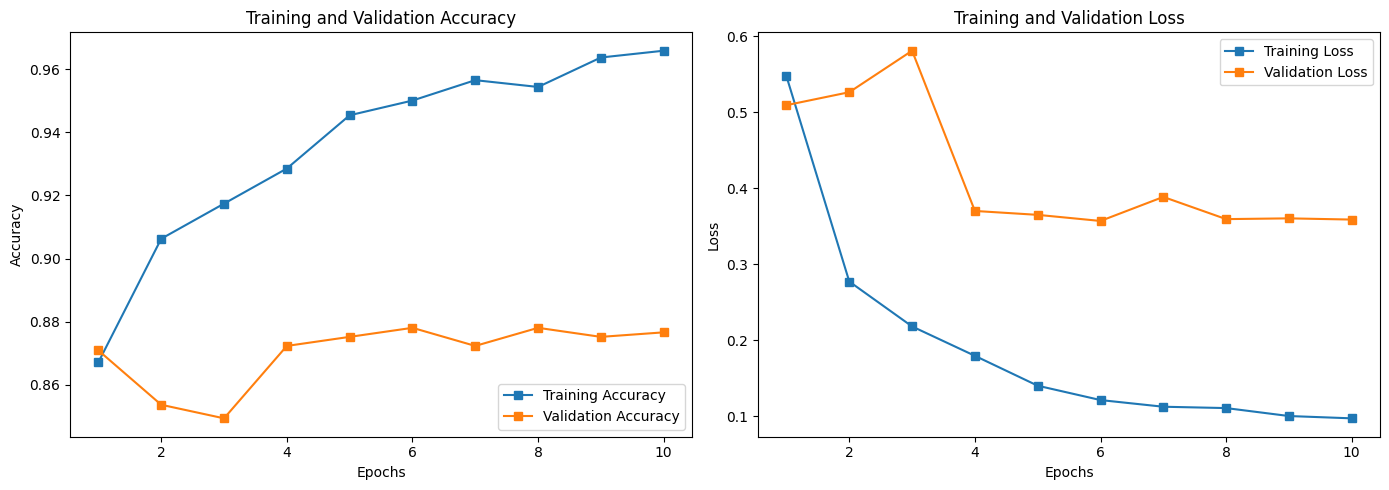

In [17]:
plot_training_history(history)

### Analyze different metrics

In [21]:
y_true = y_test
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

28/28 [==============================] - 4s 129ms/step


In [24]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Get detailed classification report
report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", report)

# Get confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Get precision, recall, F1-score, and support for each class
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred_classes)
for i in range(len(precision)):
    print(f"\nClass {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print(f"  Support: {support[i]}")


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86       416
           1       0.86      0.90      0.88       455

    accuracy                           0.87       871
   macro avg       0.87      0.87      0.87       871
weighted avg       0.87      0.87      0.87       871

Confusion Matrix:
 [[349  67]
 [ 46 409]]

Class 0:
  Precision: 0.8835
  Recall: 0.8389
  F1-score: 0.8607
  Support: 416

Class 1:
  Precision: 0.8592
  Recall: 0.8989
  F1-score: 0.8786
  Support: 455


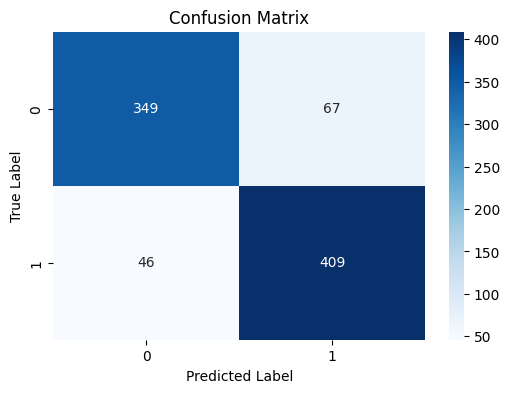

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


### Great, lest check few samples from each category

Assuming for this analyze that SANDWITCH is positive (as it has class=1) and Pizza is negative (class=0)


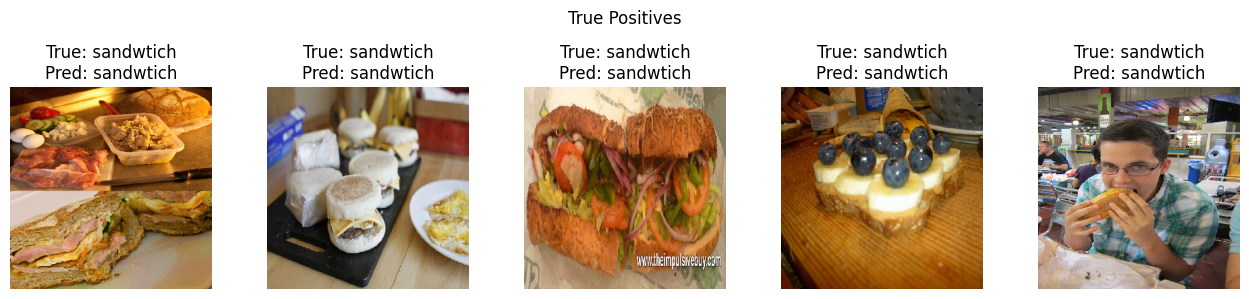

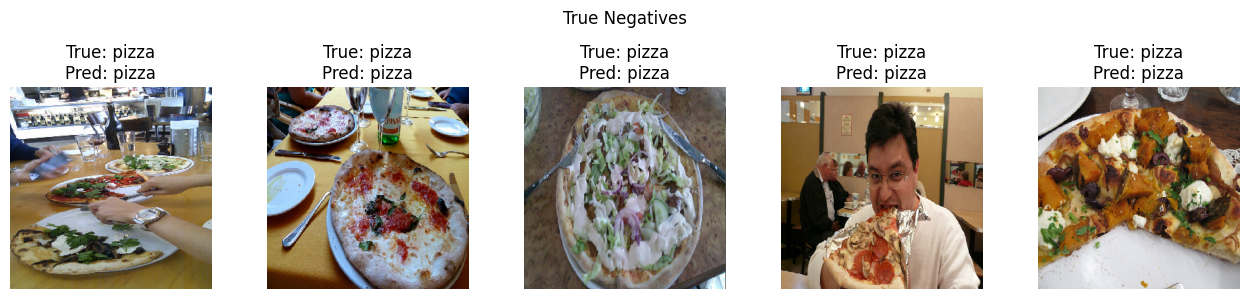

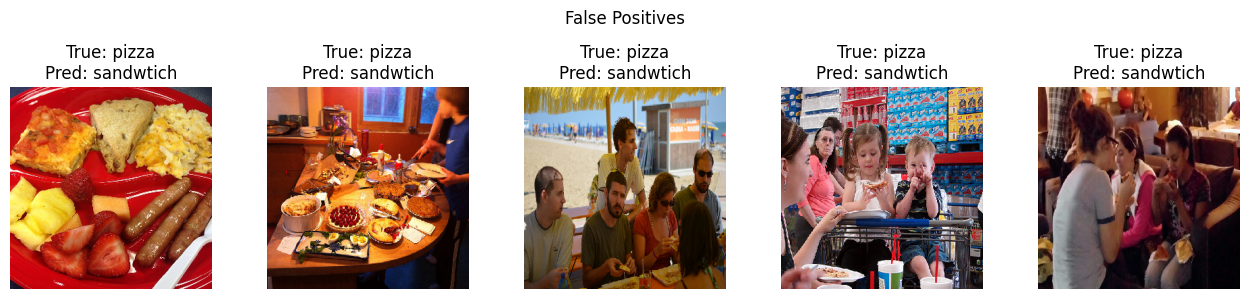

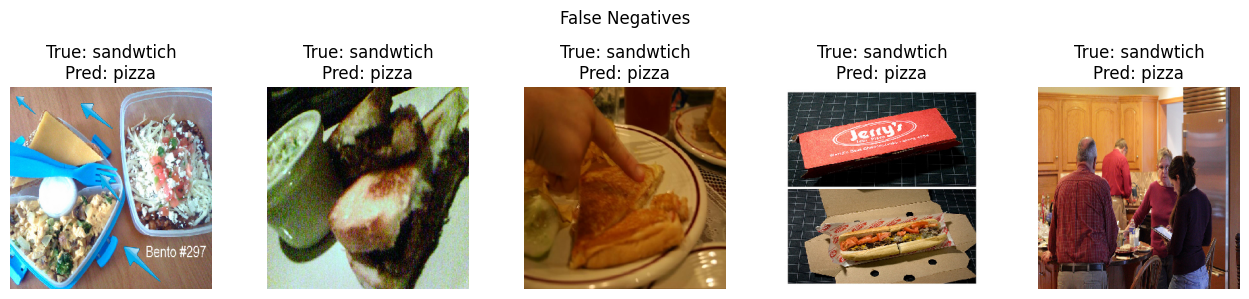

In [47]:
class_labels = {0:"pizza", 1:"sandwtich"}

import numpy as np
import matplotlib.pyplot as plt

# Function to get indices for each category
def get_indices(y_true, y_pred):
    TP = np.where((y_true == 1) & (y_pred == 1))[0]
    TN = np.where((y_true == 0) & (y_pred == 0))[0]
    FP = np.where((y_true == 0) & (y_pred == 1))[0]
    FN = np.where((y_true == 1) & (y_pred == 0))[0]
    return TP, TN, FP, FN

# Get indices for each category
TP, TN, FP, FN = get_indices(y_true, y_pred_classes)

# Function to plot images
def plot_images(X, y_true, y_pred, indices, title):
    fig, axes = plt.subplots(1, 5, figsize=(13, 3))
    fig.suptitle(title)
    for i, ax in enumerate(axes):
        if i < len(indices):
            idx = indices[i]
            # Rescale the image from [-1, 1] to [0, 1] range, otherwise it will be dark during preview
            img = (X[idx] + 1) / 2.0
            img = np.clip(img, 0, 1)  # Ensure values are within [0, 1]
            ax.imshow(img)
            ax.set_title(f"True: {class_labels[y_true[idx]]}\nPred: {class_labels[y_pred[idx]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Plot 3 samples for each category
print("Assuming for this analyze that SANDWITCH is positive (as it has class=1) and Pizza is negative (class=0)")
plot_images(X_test, y_true, y_pred_classes, TP[:5], "True Positives\n")
plot_images(X_test, y_true, y_pred_classes, TN[:5], "True Negatives\n")
plot_images(X_test, y_true, y_pred_classes, FP[:5], "False Positives\n")
plot_images(X_test, y_true, y_pred_classes, FN[:5], "False Negatives\n")


### Conclusion
- most samples that model is mistaken contains both, pizza & sandwitch
- In some cases it may be not obvious for human to determine
- As dataset has multiple instances of objects at the single picture and xception model was not created to this task i think we have solid baseline